# Lamp Failure Prediction

In [1]:
# Importation des bibliothèques principales
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# Outils de machine learning depuis scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


In [3]:
# Définition du chemin vers le fichier CSV
file_path = 'data/street_light_fault_prediction_dataset.csv'

# Chargement du dataset
df = pd.read_csv(file_path)

# Conversion du champ temporel en format datetime 
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Aperçu des premières lignes du DataFrame 
df.head()


,bulb_number,timestamp,power_consumption (Watts),voltage_levels (Volts),current_fluctuations (Amperes),temperature (Celsius),environmental_conditions,current_fluctuations_env (Amperes),fault_type
0,1,2023-09-06 07:53:23,106.18,238.52,6.127984,21.97,Rainy,0.780000,1
1,1,2023-03-28 16:28:29,58.71,235.99,3.010000,24.16,Clear,0.100000,0
2,1,2023-09-20 19:17:46,195.49,234.97,1.060000,13.64,Rainy,0.920000,0
3,1,2023-02-03 18:19:43,95.64,225.74,2.160000,15.82,Rainy,3.060000,0
4,1,2023-01-12 13:43:48,70.92,218.76,1.830000,19.12,Rainy,6.529021,4


In [5]:
# Statistiques descriptives du jeu de données
df.describe()

,bulb_number,timestamp,power_consumption (Watts),voltage_levels (Volts),current_fluctuations (Amperes),temperature (Celsius),current_fluctuations_env (Amperes),fault_type
count,34310.000000,34310,34310.000000,34310.000000,34310.000000,34310.000000,34310.000000,34310.000000
mean,47.500000,2023-07-02 22:07:46.138210560,123.089437,225.694952,2.665172,20.026780,2.865040,0.841708
min,1.000000,2023-01-01 00:33:30,21.518042,210.000000,0.000000,10.000000,0.000000,0.000000
25%,24.000000,2023-04-03 13:44:37.750000128,85.929269,217.740000,1.310000,15.020000,1.400000,0.000000
50%,47.500000,2023-07-02 15:20:40,123.241718,225.660000,2.600000,20.040000,2.800000,0.000000
75%,71.000000,2023-10-01 08:58:27,160.149951,233.250000,3.900000,25.030000,4.110000,1.000000
max,94.000000,2023-12-31 23:46:21,200.000000,259.305759,9.960166,30.000000,9.882978,4.000000
std,27.134323,NaN,43.484856,9.324979,1.648494,5.772737,1.804107,1.419514


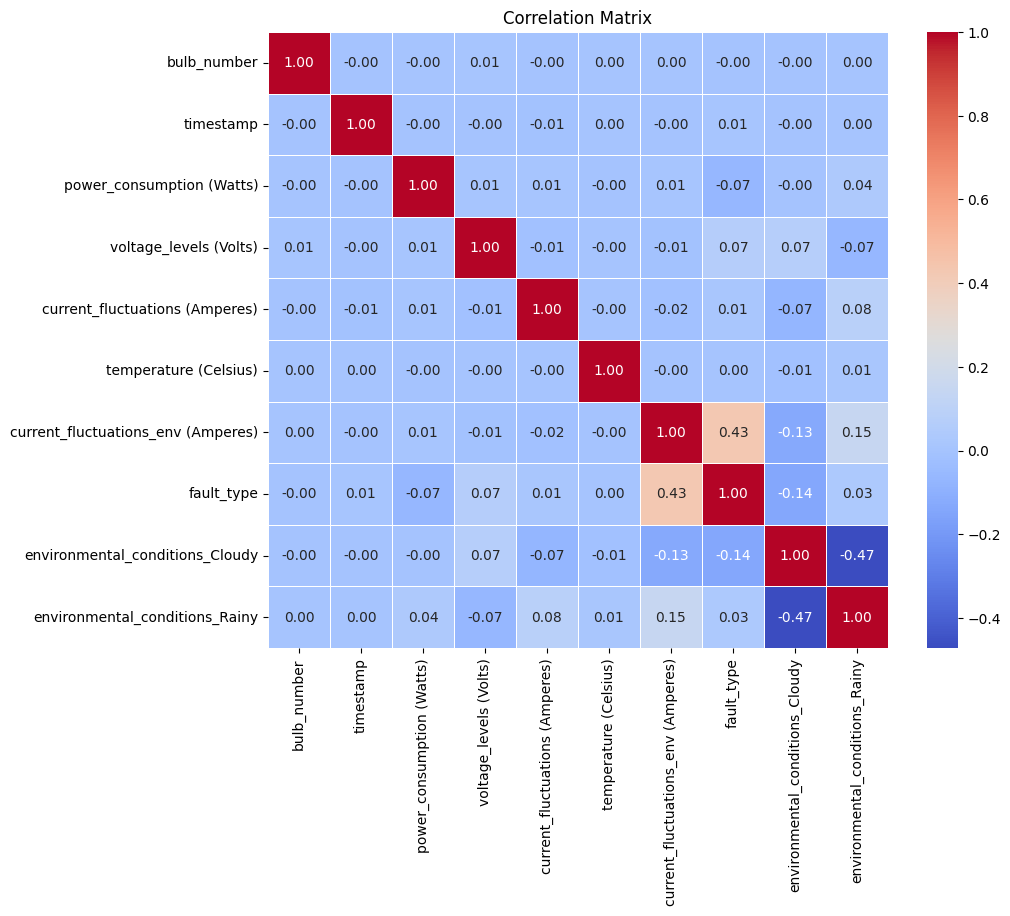

In [7]:
# Encodage des variables catégorielles
df1 = pd.get_dummies(df, columns=['environmental_conditions'], drop_first=True)

# Calcul de la matrice de corrélation
correlation_matrix = df1.corr()

# Visualisation de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
# Titre du graphique
plt.title("Correlation Matrix")
# Affiche la heatmap à l’écran
plt.show()

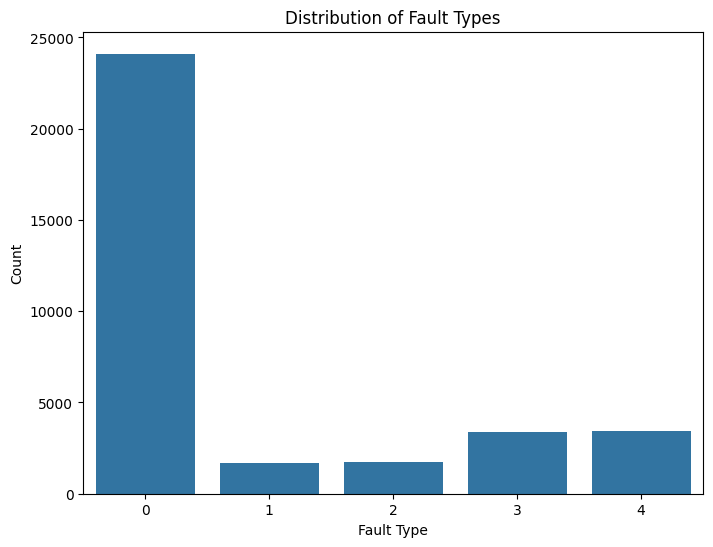

In [9]:
# Visualisation de la répartition des types de pannes
plt.figure(figsize=(8, 6)) # Définit la taille de la figure

# Crée un diagramme en barres montrant le nombre d’occurrences de chaque type de panne dans la colonne 'fault_type'
sns.countplot(x='fault_type', data=df)

# Titre du graphique
plt.title("Distribution of Fault Types")

# Étiquette de l’axe des abscisses
plt.xlabel("Fault Type")

# Étiquette de l’axe des ordonnées
plt.ylabel("Count")

# Affiche le graphique
plt.show()

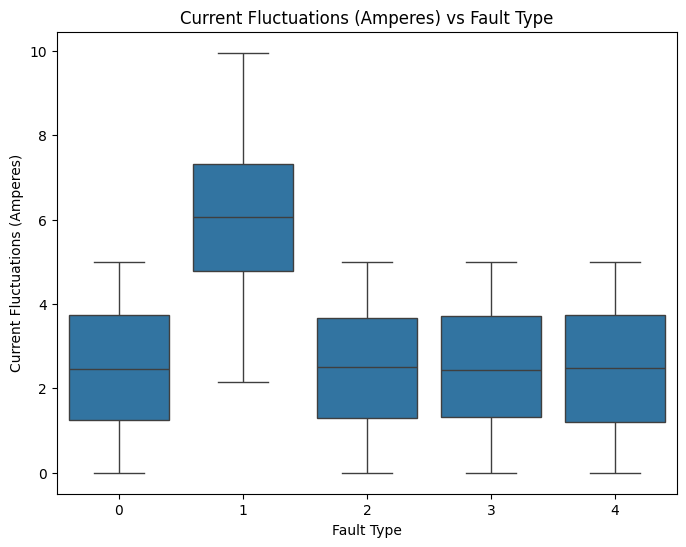

In [11]:
# Visualisation de la relation entre le type de panne et les fluctuations de courant
plt.figure(figsize=(8, 6))  # Définition de la taille du graphique

# Création d’un boxplot pour visualiser la distribution des fluctuations de courant (ampères) en fonction des différents types de pannes (fault_type)
sns.boxplot(x='fault_type', y='current_fluctuations (Amperes)', data=df)

# Ajout d’un titre
plt.title("Current Fluctuations (Amperes) vs Fault Type")

# Étiquettes des axes
plt.xlabel("Fault Type")  # Axe X : les différents types de pannes
plt.ylabel("Current Fluctuations (Amperes)")  # Axe Y : intensité du courant

# Affichage du graphique
plt.show()

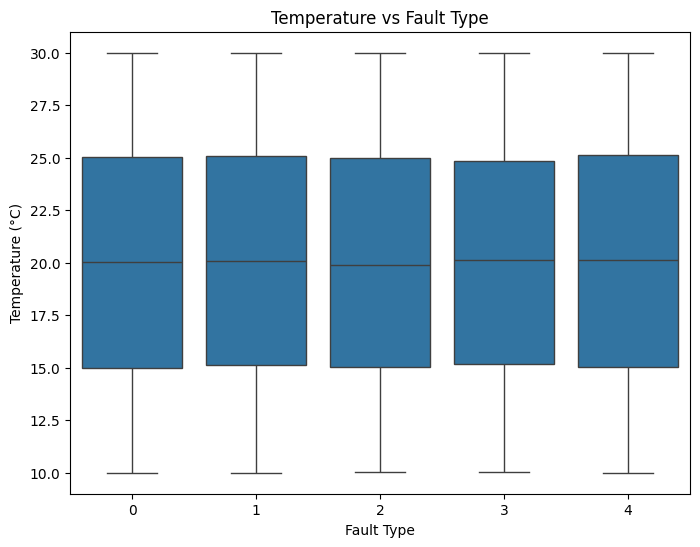

In [13]:
# Visualisation de la relation entre le type de panne et la température
plt.figure(figsize=(8, 6))  # Définition de la taille du graphique

# Création d’un boxplot pour visualiser la distribution de la température (°C) en fonction des différents types de pannes (fault_type)
sns.boxplot(x='fault_type', y='temperature (Celsius)', data=df)

# Ajout d’un titre
plt.title("Temperature vs Fault Type")

# Étiquettes des axes
plt.xlabel("Fault Type")  # Axe X : les différents types de pannes
plt.ylabel("Temperature (°C)")  # Axe Y : température en degrés Celsius

# Affichage du graphique
plt.show()

In [15]:
# Copier le DataFrame pour chaque modèle
df_rf = df.copy(deep=True)   # Pour Random Forest
df_lr = df.copy(deep=True)   # Pour Logistic Regression

# Logistic Regression

In [17]:
# Définition des variables explicatives (features) et de la cible (target)
features_lr = ['power_consumption (Watts)', 'voltage_levels (Volts)', 'current_fluctuations (Amperes)', 'temperature (Celsius)', 'current_fluctuations_env (Amperes)']
target = 'fault_type'

# Nettoyage et conversion des données numériques
for feature in features_lr:
    df_lr[feature] = pd.to_numeric(df_lr[feature].astype(str).replace('[^0-9.]', '', regex=True), errors='coerce')

# Encodage des variables catégorielles
df_lr = pd.get_dummies(df_lr, columns=['environmental_conditions'], drop_first=True)

# Préparation des données
X = df_lr[features_lr + list(df_lr.columns[df_lr.columns.str.startswith('environmental_conditions')])]
y = df_lr[target]

# Standardisation des features numériques pour la régression logistique
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation en train / test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entraînement du modèle
log_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
log_model.fit(X_train, y_train)

# Prédiction
y_pred = log_model.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=0)

print(f"Accuracy (Logistic Regression): {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Accuracy (Logistic Regression): 0.83

Confusion Matrix:
[[4835    0    0    0   28]
 [  90  222    0    0    1]
 [ 180    0  135    0    0]
 [ 663    0    0    0    0]
 [ 226    0    0    0  482]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      4863
           1       1.00      0.71      0.83       313
           2       1.00      0.43      0.60       315
           3       0.00      0.00      0.00       663
           4       0.94      0.68      0.79       708

    accuracy                           0.83      6862
   macro avg       0.75      0.56      0.62      6862
weighted avg       0.76      0.83      0.78      6862



In [37]:
# Liste des exemples manuels
manual_examples_lr = [
    {
        'power_consumption (Watts)': 48.423,
        'voltage_levels (Volts)': 218.93,
        'current_fluctuations (Amperes)': 3.01,
        'temperature (Celsius)': 28.34,
        'current_fluctuations_env (Amperes)': 1.95,
        'environmental_conditions_Cloudy': 0,
        'environmental_conditions_Rainy': 0
    },
    {
        'power_consumption (Watts)': 176.39,
        'voltage_levels (Volts)': 213.09,
        'current_fluctuations (Amperes)': 3.64,
        'temperature (Celsius)': 23.2,
        'current_fluctuations_env (Amperes)': 7.106,
        'environmental_conditions_Cloudy': 0,
        'environmental_conditions_Rainy': 0
    },
    {
        'power_consumption (Watts)': 157.14,
        'voltage_levels (Volts)': 228.39,
        'current_fluctuations (Amperes)': 6.849,
        'temperature (Celsius)': 24.38,
        'current_fluctuations_env (Amperes)': 1.06,
        'environmental_conditions_Cloudy': 0,
        'environmental_conditions_Rainy': 0
    },
    {
        'power_consumption (Watts)': 107.45,
        'voltage_levels (Volts)': 248.126,
        'current_fluctuations (Amperes)': 0.7,
        'temperature (Celsius)': 23.36,
        'current_fluctuations_env (Amperes)': 4.77,
        'environmental_conditions_Cloudy': 1,
        'environmental_conditions_Rainy': 0
    },
    {
        'power_consumption (Watts)': 187.86,
        'voltage_levels (Volts)': 212.43,
        'current_fluctuations (Amperes)': 4.28,
        'temperature (Celsius)': 21.59,
        'current_fluctuations_env (Amperes)': 2.04,
        'environmental_conditions_Cloudy': 0,
        'environmental_conditions_Rainy': 1
    }
]

# Création du DataFrame
manual_df_lr = pd.DataFrame(manual_examples_lr)

# Standardisation des valeurs numériques
manual_scaled = scaler.transform(manual_df_lr)

# Prédiction
manual_preds = log_model.predict(manual_scaled)

# Affichage des résultats
for i, pred in enumerate(manual_preds, 1):
    print(f"Manual Example {i} - Predicted Fault Type: {pred}")


Manual Example 1 - Predicted Fault Type: 0
Manual Example 2 - Predicted Fault Type: 4
Manual Example 3 - Predicted Fault Type: 1
Manual Example 4 - Predicted Fault Type: 2
Manual Example 5 - Predicted Fault Type: 0


# Random Forest

In [19]:
# Définition des variables explicatives (features) et de la cible (target)
features_rf = ['power_consumption (Watts)', 'voltage_levels (Volts)', 'current_fluctuations (Amperes)', 'temperature (Celsius)', 'current_fluctuations_env (Amperes)']
target = 'fault_type'

# Nettoyage et conversion des données numériques
for feature in features_rf:
    df_rf[feature] = pd.to_numeric(df_rf[feature].astype(str).replace('[^0-9.]', '', regex=True), errors='coerce')


# Encodage des variables catégorielles
df_rf = pd.get_dummies(df_rf, columns=['environmental_conditions'], drop_first=True)

# Séparation des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(df_rf[features_rf + list(df_rf.columns[df_rf.columns.str.startswith('environmental_conditions')])], df_rf[target], test_size=0.2, random_state=42)

# Entraînement du modèle Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Prédiction sur l’ensemble de test
y_pred = rf_model.predict(X_test)

# Évaluation du modèle
# Mesure la proportion de bonnes prédictions
accuracy = accuracy_score(y_test, y_pred)
# Compare les prédictions vs les vraies classes pour chaque type de panne
conf_matrix = confusion_matrix(y_test, y_pred)
# Fournit précision, rappel et F1-score pour chaque classe
class_report = classification_report(y_test, y_pred)

# Affichage des résultats
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)



Accuracy: 0.85

Confusion Matrix:
[[4844    0    0   17    2]
 [  78  235    0    0    0]
 [ 160    0  154    1    0]
 [ 571    0    0   92    0]
 [ 220    0    0    0  488]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4863
           1       1.00      0.75      0.86       313
           2       1.00      0.49      0.66       315
           3       0.84      0.14      0.24       663
           4       1.00      0.69      0.81       708

    accuracy                           0.85      6862
   macro avg       0.93      0.61      0.69      6862
weighted avg       0.86      0.85      0.82      6862



In [21]:
# Affichage des noms de variables utilisés pendant l'entraînement du modèle
print("Feature names during model training:")
print(rf_model.feature_names_in_)


Feature names during model training:
['power_consumption (Watts)' 'voltage_levels (Volts)'
 'current_fluctuations (Amperes)' 'temperature (Celsius)'
 'current_fluctuations_env (Amperes)' 'environmental_conditions_Cloudy'
 'environmental_conditions_Rainy']


In [23]:
# Création d’un dictionnaire avec des valeurs manuelles pour prédiction
manual_values = {
    'power_consumption (Watts)': 48.423,
    'voltage_levels (Volts)': 218.93,
    'current_fluctuations (Amperes)': 3.01,
    'temperature (Celsius)': 28.34,
    'current_fluctuations_env (Amperes)': 1.95,
    'environmental_conditions_Cloudy': False,
    'environmental_conditions_Rainy': False
}

# Conversion du dictionnaire en DataFrame
manual_df = pd.DataFrame([manual_values])

# Assurer la conversion en valeurs numériques pour les colonnes de features
for feature in features_rf:
    manual_df[feature] = pd.to_numeric(manual_df[feature], errors='coerce')

# Prédiction avec le modèle Random Forest
manual_pred = rf_model.predict(manual_df)

# Affichage du résultat
print("Manual Prediction:")
print("Predicted Fault Type:", manual_pred[0])


Manual Prediction:
Predicted Fault Type: 3


In [25]:
# Création d’un second exemple manuel pour prédiction
manual_values_2 = {
    'power_consumption (Watts)': 176.39,
    'voltage_levels (Volts)': 213.09,
    'current_fluctuations (Amperes)': 3.64,
    'temperature (Celsius)': 23.2,
    'current_fluctuations_env (Amperes)': 7.106,
    'environmental_conditions_Cloudy': False,
    'environmental_conditions_Rainy': False
}

# Conversion du dictionnaire en DataFrame
manual_df_2 = pd.DataFrame([manual_values_2])

# Conversion des colonnes de features en valeurs numériques
for feature in features_rf:
    manual_df_2[feature] = pd.to_numeric(manual_df_2[feature], errors='coerce')

# Prédiction du type de panne avec le modèle Random Forest
manual_pred_2 = rf_model.predict(manual_df_2)

# Affichage du résultat
print("Manual Prediction:")
print("Predicted Fault Type:", manual_pred_2[0])


Manual Prediction:
Predicted Fault Type: 4


In [27]:
# Création d’un troisième exemple manuel pour prédiction
manual_values_3 = {
    'power_consumption (Watts)': 157.14,
    'voltage_levels (Volts)': 228.39,
    'current_fluctuations (Amperes)': 6.849,
    'temperature (Celsius)': 24.38,
    'current_fluctuations_env (Amperes)': 1.06,
    'environmental_conditions_Cloudy': False,
    'environmental_conditions_Rainy': False
}

# Conversion du dictionnaire en DataFrame
manual_df_3 = pd.DataFrame([manual_values_3])

# Conversion des colonnes de features en valeurs numériques
for feature in features_rf:
    manual_df_3[feature] = pd.to_numeric(manual_df_3[feature], errors='coerce')

# Prédiction du type de panne avec le modèle Random Forest
manual_pred_3 = rf_model.predict(manual_df_3)

# Affichage du résultat
print("Manual Prediction:")
print("Predicted Fault Type:", manual_pred_3[0])


Manual Prediction:
Predicted Fault Type: 1


In [29]:
# Création d’un quatrième exemple manuel pour prédiction
manual_values_4 = {
    'power_consumption (Watts)': 107.45,
    'voltage_levels (Volts)': 248.126,
    'current_fluctuations (Amperes)': 0.7,
    'temperature (Celsius)': 23.36,
    'current_fluctuations_env (Amperes)': 4.77,
    'environmental_conditions_Cloudy': True,
    'environmental_conditions_Rainy': False
}

# Conversion du dictionnaire en DataFrame
manual_df_4 = pd.DataFrame([manual_values_4])

# Conversion des colonnes de features en valeurs numériques
for feature in features_rf:
    manual_df_4[feature] = pd.to_numeric(manual_df_4[feature], errors='coerce')

# Prédiction du type de panne avec le modèle Random Forest
manual_pred_4 = rf_model.predict(manual_df_4)

# Affichage du résultat
print("Manual Prediction:")
print("Predicted Fault Type:", manual_pred_4[0])


Manual Prediction:
Predicted Fault Type: 2


In [31]:
# Création d’un cinquième exemple manuel pour prédiction 
manual_values_5 = {
    'power_consumption (Watts)': 187.86,
    'voltage_levels (Volts)': 212.43,
    'current_fluctuations (Amperes)': 4.28,
    'temperature (Celsius)': 21.59,
    'current_fluctuations_env (Amperes)': 2.04,
    'environmental_conditions_Cloudy': False,
    'environmental_conditions_Rainy': True
}

# Conversion du dictionnaire en DataFrame
manual_df_5 = pd.DataFrame([manual_values_5])

# Conversion des colonnes de features en valeurs numériques
for feature in features_rf:
    manual_df_5[feature] = pd.to_numeric(manual_df_5[feature], errors='coerce')

# Prédiction du type de panne avec le modèle Random Forest
manual_pred_5 = rf_model.predict(manual_df_5)

# Affichage du résultat
print("Manual Prediction:")
print("Predicted Fault Type:", manual_pred_5[0])


Manual Prediction:
Predicted Fault Type: 0
